In [1]:
import pandas as pd
import numpy as np
import math
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('TGI_BARCODE_LOOKUP.CSV', encoding = 'latin1', dtype=str)
barcodes = df['BARCODE']
df = ''
df = pd.read_csv('TGI_BARCODE_LOOKUP.CSV', encoding = 'latin1')
df['BARCODE'] = barcodes

/Users/Tazman/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.shape

(109103, 22)

# Determine category

In [4]:
df2 = pd.read_excel('2018 dataset.xlsx', dtype=str)
barcodes = df2['Gtin']
df2 = ''
df2 = pd.read_excel('2018 dataset.xlsx', dtype=str)
df2['Gtin'] = barcodes

In [5]:
df2.drop_duplicates(subset = 'Gtin', inplace=True)

In [6]:
df2.replace('nan', np.NaN, inplace=True)

In [7]:
df = df.merge(df2[['Gtin', 'Leaf category', 'Group Master Food Group Code', 'Energy (kJ) Per 100 ( kJ )', 'HSR Score', 'Presence HSR', 'Package Size']], how='left', left_on = 'BARCODE', right_on = 'Gtin')


In [8]:
def strip_size(string):
    try:
        end = string.split(' ')[-1][0]
        if int(end)>0:
            return ' '.join(string.split(' ')[:-1]).lower()
        else:
            return string.lower()
    except:
        return string.lower()

In [9]:
df['BC DESC CLEAN'] = df['BC DESC'].fillna('0').apply(strip_size)

In [10]:
df3 = df[['BC DESC CLEAN', 'Group Master Food Group Code']]
df3 = df3[~df3['Group Master Food Group Code'].isnull()]
df3.drop_duplicates(subset = 'BC DESC CLEAN', inplace=True)
df3.shape

(21725, 2)

In [11]:
names = df3['BC DESC CLEAN'].tolist()

In [12]:
def categorizer(string):
    if string in names:
        return df3[df3['BC DESC CLEAN'] == string]['Group Master Food Group Code'].tolist()[0]
    else:
        return np.NaN

In [13]:
df['Group Master Food Group Code 2'] = df['BC DESC CLEAN'].apply(categorizer)

In [14]:
c1 = (df['Group Master Food Group Code'].isnull())
df['Group Master Food Group Code'] = np.where(c1, df['Group Master Food Group Code 2'], df['Group Master Food Group Code'])


In [862]:
df4 = pd.read_excel('scanguide.xlsx', sheet_name = 'Packaged products')

In [863]:
df['Group Master Food Group Code'] = df['Group Master Food Group Code'].fillna('99999999').astype(int)

In [864]:
df = df.merge(df4[['Group Code', 'Group Name','CPI category']], how = 'left', left_on = 'Group Master Food Group Code', right_on = 'Group Code')

In [865]:
df5 = pd.read_excel('scanguide.xlsx', sheet_name = 'Non-packaged products')

In [866]:
df5.columns = ['BARCODE', 'BC DESC', 'CPI category z']

In [867]:
df5['BARCODE'] = df5['BARCODE'].astype(str)

In [868]:
df = df.merge(df5[['BARCODE','CPI category z']], how = 'left', left_on = 'BARCODE', right_on = 'BARCODE')

In [869]:
c1 = (df['CPI category'].isnull())
df['CPI category'] = np.where(c1, df['CPI category z'], df['CPI category'])

In [870]:
df = df[~df['CPI category'].isnull()]

In [871]:
df['CPI category'] = df['CPI category'].str.lstrip().str.rstrip()

In [872]:
df['CPI category'] = df['CPI category'].str.replace('Ice cream&other dairy prod  EC',
    'Ice cream & other dairy products EC')

# Determining NPSC

In [873]:
c1 = (df2['Fibre Per 100 ( g )'].isnull())

df2['Fibre Per 100 ( g )'] = np.where(c1, df2['Group Default Fibre'], df2['Fibre Per 100 ( g )'])

In [874]:
df2['Combine'] = df2['Energy (kJ) Per 100 ( kJ )'].astype(str) + '|' + df2['Protein Per 100 ( g )'].astype(str) + '|'  + df2['Saturated fat Per 100 ( g )'].astype(str) + '|'  + df2['Sugars Per 100 ( g )'].astype(str) + '|'  + df2['Sodium (mg) Per 100 ( mg )'].astype(str) + '|'  + df2['Fibre Per 100 ( g )'].astype(str) + '|'  + df2['Group V Points'].astype(str) + '|'  + df2['Group Health Star Category'].astype(str)



In [875]:
df2 = df2[~(df2['Combine'].str.contains('nan'))]

In [349]:
#dl = df2

In [350]:
#dl['Calculated HSR points'] = dl['Calculated HSR points'].astype(float)

In [351]:
#dl['HSR points'] = dl['HSR points'].astype(float)

In [356]:
#c1 = (dl['Calculated HSR points'] != dl['HSR points'])
#c2 = (~dl['HSR points'].isnull())
#df2[c1&c2][['Product Name','Energy (kJ) Per 100 ( kJ )', 'Saturated fat Per 100 ( g )',
#             'Sugars Per 100 ( g )','Sodium (mg) Per 100 ( mg )',
#            'Protein Per 100 ( g )',   'Fibre Per 100 ( g )', 'Group V Points', 'Group Health Star Category',
#            'Calculated HSR points', 'HSR points', 'Product Id']]


In [876]:
def NPSC_3(combine):

    energy = float(combine.split('|')[0])
    protein = float(combine.split('|')[1])
    sat_fat = float(combine.split('|')[2])
    sugar = float(combine.split('|')[3])
    sodium = float(combine.split('|')[4])
    fibre = float(combine.split('|')[5])
    FVNL = float(combine.split('|')[6]) 
    

    
    if energy<=335:
        energy_points = 0
    if energy>3685:
        energy_points = 11
    if (energy > 335) & (energy<=3685):
        energy_points = math.floor((energy/335)-0.001)
        
    if sat_fat<=1:
        sat_fat_points = 0
    if sat_fat>1:
        sat_fat_points = 1
    if sat_fat>2:
        sat_fat_points = 2
    if sat_fat>3:
        sat_fat_points = 3
    if sat_fat>4:
        sat_fat_points = 4
    if sat_fat>5:
        sat_fat_points = 5
    if sat_fat>6:
        sat_fat_points = 6
    if sat_fat>7:
        sat_fat_points = 7
    if sat_fat>8:
        sat_fat_points = 8
    if sat_fat>9:
        sat_fat_points = 9
    if sat_fat>10:
        sat_fat_points = 10
    if sat_fat>11:
        sat_fat_points = 11
    if sat_fat>12:
        sat_fat_points = 12
    if sat_fat>13:
        sat_fat_points = 13
    if sat_fat>14:
        sat_fat_points = 14
    if sat_fat>15:
        sat_fat_points = 15
    if sat_fat>16:
        sat_fat_points = 16
    if sat_fat>17:
        sat_fat_points = 17
    if sat_fat>18:
        sat_fat_points = 18
    if sat_fat>19:
        sat_fat_points = 19
    if sat_fat>20:
        sat_fat_points = 20
    if sat_fat>21:
        sat_fat_points = 21
    if sat_fat>22:
        sat_fat_points = 22
    if sat_fat>23:
        sat_fat_points = 23
    if sat_fat>24:
        sat_fat_points = 24
    if sat_fat>25:
        sat_fat_points = 25
    if sat_fat>26:
        sat_fat_points = 26
    if sat_fat>27:
        sat_fat_points = 27
    if sat_fat>28:
        sat_fat_points = 28
    if sat_fat>29:
        sat_fat_points = 29
    if sat_fat>30:
        sat_fat_points = 30

    
    if sugar<=5:
        sugar_points = 0
    if sugar>5:
        sugar_points = 1
    if sugar>9:
        sugar_points = 2
    if sugar>13.5:
        sugar_points = 3
    if sugar>18:
        sugar_points = 4
    if sugar>22.5:
        sugar_points = 5
    if sugar>27:
        sugar_points = 6
    if sugar>31:
        sugar_points = 7
    if sugar>36:
        sugar_points = 8
    if sugar>40:
        sugar_points = 9
    if sugar>45:
        sugar_points = 10
        



    
    if sodium<=90:
        sodium_points = 0
    if sodium>90:
        sodium_points = 1
    if sodium>180:
        sodium_points = 2
    if sodium>270:
        sodium_points = 3
    if sodium>360:
        sodium_points = 4
    if sodium>450:
        sodium_points = 5
    if sodium>540:
        sodium_points = 6
    if sodium>630:
        sodium_points = 7
    if sodium>720:
        sodium_points = 8
    if sodium>810:
        sodium_points = 9
    if sodium>900:
        sodium_points = 10
    if sodium>990:
        sodium_points = 11
    if sodium>1080:
        sodium_points = 12
    if sodium>1170:
        sodium_points = 13
    if sodium>1260:
        sodium_points = 14
    if sodium>1350:
        sodium_points = 15
    if sodium>1440:
        sodium_points = 16
    if sodium>1530:
        sodium_points = 17
    if sodium>1620:
        sodium_points = 18
    if sodium>1710:
        sodium_points = 19
    if sodium>1800:
        sodium_points = 20
    if sodium>1890:
        sodium_points = 21
    if sodium>1980:
        sodium_points = 22
    if sodium>2070:
        sodium_points = 23
    if sodium>2160:
        sodium_points = 24
    if sodium>2250:
        sodium_points = 25
    if sodium>2340:
        sodium_points = 26
    if sodium>2430:
        sodium_points = 27
    if sodium>2520:
        sodium_points = 28
    if sodium>2610:
        sodium_points = 29
    if sodium>2700:
        sodium_points = 30
        
    baseline_points =  energy_points + sat_fat_points + sugar_points + sodium_points
    
    
    
    FVNL_points = FVNL
    
    
    if protein<=1.6:
        protein_points = 0
    if protein>1.6:
        protein_points = 1
    if protein>=3.2:
        protein_points = 2
    if protein>4.8:
        protein_points = 3
    if protein>6.4:
        protein_points = 4
    if protein>8:
        protein_points = 5
    if protein>9.6:
        protein_points = 6
    if protein>11.6:
        protein_points = 7
    if protein>13.9:
        protein_points = 8
    if protein>16.7:
        protein_points = 9
    if protein>20:
        protein_points = 10
    if protein>24:
        protein_points = 11
    if protein>28.9:
        protein_points = 12
    if protein>34.7:
        protein_points = 13
    if protein>41.6:
        protein_points = 14
    if protein>50:
        protein_points = 15

        
 
    if fibre<=0.9:
        fibre_points = 0
    if fibre>0.9:
        fibre_points = 1
    if fibre>1.9:
        fibre_points = 2
    if fibre>2.8:
        fibre_points = 3
    if fibre>3.7:
        fibre_points = 4
    if fibre>4.7:
        fibre_points = 5
    if fibre>5.4:
        fibre_points = 6
    if fibre>6.3:
        fibre_points = 7
    if fibre>7.3:
        fibre_points = 8
    if fibre>8.4:
        fibre_points = 9
    if fibre>9.7:
        fibre_points = 10
    if fibre>11.2:
        fibre_points = 11
    if fibre>13:
        fibre_points = 12
    if fibre>15:
        fibre_points = 13
    if fibre>17.3:
        fibre_points = 14
    if fibre>20:
        fibre_points = 15      
    
    if (baseline_points >= 13) & (FVNL_points<5):
        protein_points = 0
    
    total_points = baseline_points - FVNL_points - protein_points - fibre_points
    return total_points

In [877]:
def NPSC(combine):
    
    
    
    
    energy = float(combine.split('|')[0])
    protein = float(combine.split('|')[1])
    sat_fat = float(combine.split('|')[2])
    sugar = float(combine.split('|')[3])
    sodium = float(combine.split('|')[4])
    fibre = float(combine.split('|')[5])
    FVNL = float(combine.split('|')[6]) 
    
    
    
    
    
    
    
    if energy<=335:
        energy_points = 0
    if energy>3685:
        energy_points = 11
    if (energy > 335) & (energy<=3685):
        energy_points = math.floor((energy/335)-0.001)
        
    if sat_fat<=1:
        sat_fat_points = 0
    if sat_fat>1:
        sat_fat_points = 1
    if sat_fat>2:
        sat_fat_points = 2
    if sat_fat>3:
        sat_fat_points = 3
    if sat_fat>4:
        sat_fat_points = 4
    if sat_fat>5:
        sat_fat_points = 5
    if sat_fat>6:
        sat_fat_points = 6
    if sat_fat>7:
        sat_fat_points = 7
    if sat_fat>8:
        sat_fat_points = 8
    if sat_fat>9:
        sat_fat_points = 9
    if sat_fat>10:
        sat_fat_points = 10
    if sat_fat>11.2:
        sat_fat_points = 11
    if sat_fat>12.5:
        sat_fat_points = 12
    if sat_fat>13.9:
        sat_fat_points = 13
    if sat_fat>15.5:
        sat_fat_points = 14
    if sat_fat>17.3:
        sat_fat_points = 15
    if sat_fat>19.3:
        sat_fat_points = 16
    if sat_fat>21.6:
        sat_fat_points = 17
    if sat_fat>24.1:
        sat_fat_points = 18
    if sat_fat>26.9:
        sat_fat_points = 19
    if sat_fat>30:
        sat_fat_points = 20
    if sat_fat>33.5:
        sat_fat_points = 21
    if sat_fat>37.4:
        sat_fat_points = 22
    if sat_fat>41.7:
        sat_fat_points = 23
    if sat_fat>46.6:
        sat_fat_points = 24
    if sat_fat>52:
        sat_fat_points = 25
    if sat_fat>58:
        sat_fat_points = 26
    if sat_fat>64.7:
        sat_fat_points = 27
    if sat_fat>72.3:
        sat_fat_points = 28
    if sat_fat>80.6:
        sat_fat_points = 29
    if sat_fat>90:
        sat_fat_points = 30

    
    if sugar<=5:
        sugar_points = 0
    if sugar>5:
        sugar_points = 1
    if sugar>9:
        sugar_points = 2
    if sugar>13.5:
        sugar_points = 3
    if sugar>18:
        sugar_points = 4
    if sugar>22.5:
        sugar_points = 5
    if sugar>27:
        sugar_points = 6
    if sugar>31:
        sugar_points = 7
    if sugar>36:
        sugar_points = 8
    if sugar>40:
        sugar_points = 9
    if sugar>45:
        sugar_points = 10
    if sugar>49:
        sugar_points = 11
    if sugar>54:
        sugar_points = 12
    if sugar>58:
        sugar_points = 13
    if sugar>63:
        sugar_points = 14
    if sugar>67:
        sugar_points = 15
    if sugar>72:
        sugar_points = 16
    if sugar>76:
        sugar_points = 17
    if sugar>81:
        sugar_points = 18
    if sugar>85:
        sugar_points = 19
    if sugar>90:
        sugar_points = 20
    if sugar>94:
        sugar_points = 21
    if sugar>99:
        sugar_points = 22


    
    if sodium<=90:
        sodium_points = 0
    if sodium>90:
        sodium_points = 1
    if sodium>180:
        sodium_points = 2
    if sodium>270:
        sodium_points = 3
    if sodium>360:
        sodium_points = 4
    if sodium>450:
        sodium_points = 5
    if sodium>540:
        sodium_points = 6
    if sodium>630:
        sodium_points = 7
    if sodium>720:
        sodium_points = 8
    if sodium>810:
        sodium_points = 9
    if sodium>900:
        sodium_points = 10
    if sodium>1005:
        sodium_points = 11
    if sodium>1121:
        sodium_points = 12
    if sodium>1251:
        sodium_points = 13
    if sodium>1397:
        sodium_points = 14
    if sodium>1559:
        sodium_points = 15
    if sodium>1740:
        sodium_points = 16
    if sodium>1942:
        sodium_points = 17
    if sodium>2168:
        sodium_points = 18
    if sodium>2420:
        sodium_points = 19
    if sodium>2701:
        sodium_points = 20
    if sodium>3015:
        sodium_points = 21
    if sodium>3365:
        sodium_points = 22
    if sodium>3756:
        sodium_points = 23
    if sodium>4192:
        sodium_points = 24
    if sodium>4679:
        sodium_points = 25
    if sodium>5223:
        sodium_points = 26
    if sodium>5829:
        sodium_points = 27
    if sodium>6506:
        sodium_points = 28
    if sodium>7262:
        sodium_points = 29
    if sodium>8106:
        sodium_points = 30
        
    baseline_points =  energy_points + sat_fat_points + sugar_points + sodium_points
    
    
    
    FVNL_points = FVNL
    
    
    if protein<=1.6:
        protein_points = 0
    if protein>1.6:
        protein_points = 1
    if protein>=3.2:
        protein_points = 2
    if protein>4.8:
        protein_points = 3
    if protein>6.4:
        protein_points = 4
    if protein>8:
        protein_points = 5
    if protein>9.6:
        protein_points = 6
    if protein>11.6:
        protein_points = 7
    if protein>13.9:
        protein_points = 8
    if protein>16.7:
        protein_points = 9
    if protein>20:
        protein_points = 10
    if protein>24:
        protein_points = 11
    if protein>28.9:
        protein_points = 12
    if protein>34.7:
        protein_points = 13
    if protein>41.6:
        protein_points = 14
    if protein>50:
        protein_points = 15

        
 
    if fibre<=0.9:
        fibre_points = 0
    if fibre>0.9:
        fibre_points = 1
    if fibre>1.9:
        fibre_points = 2
    if fibre>2.8:
        fibre_points = 3
    if fibre>3.7:
        fibre_points = 4
    if fibre>4.7:
        fibre_points = 5
    if fibre>5.4:
        fibre_points = 6
    if fibre>6.3:
        fibre_points = 7
    if fibre>7.3:
        fibre_points = 8
    if fibre>8.4:
        fibre_points = 9
    if fibre>9.7:
        fibre_points = 10
    if fibre>11.2:
        fibre_points = 11
    if fibre>13:
        fibre_points = 12
    if fibre>15:
        fibre_points = 13
    if fibre>17.3:
        fibre_points = 14
    if fibre>20:
        fibre_points = 15      
    
    if (baseline_points >= 13) & (FVNL_points<5):
        protein_points = 0
    
    total_points = baseline_points - FVNL_points - protein_points - fibre_points
    return total_points

In [878]:
df2['Calculated HSR points'] = df2['Combine'].apply(NPSC)

c4 = (df2['Group Health Star Category'].str[0] == '3')

df2['Calculated HSR points'] = np.where(c4, df2['Combine'].apply(NPSC_3), df2['Calculated HSR points'] )

In [879]:
df2.replace('nan', np.NaN, inplace=True)

In [113]:
#df2['Combine'] = df2['Group Health Star Category'] + '|' + df2['HSR Score']

In [114]:
#df2['Mapped NPSC'] = df2['Combine'].apply(NPSC)

In [115]:
#c1 = (df2['HSR points'].isnull())
#df2['HSR points'] = np.where(c1, df2['Mapped NPSC'], df2['HSR points'])

In [880]:
df = df.merge(df2[['Gtin', 'Group Health Star Category', 'Calculated HSR points']], how = 'left', left_on = 'BARCODE', right_on = 'Gtin')
         

0

In [881]:
c1 = (df['MANUFACTURER'] != 'THE NIELSEN COMPANY')
c2 = (~df['Calculated HSR points'].isnull())
c3 = (df['MANUFACTURER'] == 'THE NIELSEN COMPANY')
df = df[(c1 & c2) | c3]

In [882]:
df.shape

(16047, 38)

In [403]:
#df2.columns.tolist()

In [883]:
df2.shape

(23703, 142)

In [884]:
def NPSC_N(combine):
    
    
    
    
    energy = float(combine.split('|')[0])
    sat_fat = float(combine.split('|')[1])
    sugar = float(combine.split('|')[2])
    sodium = float(combine.split('|')[3])
    protein = float(combine.split('|')[4])
    fibre = float(combine.split('|')[5])
    FVNL = float(combine.split('|')[6]) 
    
    
    if energy<=335:
        energy_points = 0
    if energy>3685:
        energy_points = 11
    if (energy > 335) & (energy<=3685):
        energy_points = math.floor((energy/335))
        
    if sat_fat<=1:
        sat_fat_points = 0
    if sat_fat>1:
        sat_fat_points = 1
    if sat_fat>2:
        sat_fat_points = 2
    if sat_fat>3:
        sat_fat_points = 3
    if sat_fat>4:
        sat_fat_points = 4
    if sat_fat>5:
        sat_fat_points = 5
    if sat_fat>6:
        sat_fat_points = 6
    if sat_fat>7:
        sat_fat_points = 7
    if sat_fat>8:
        sat_fat_points = 8
    if sat_fat>9:
        sat_fat_points = 9
    if sat_fat>10:
        sat_fat_points = 10
    if sat_fat>11.2:
        sat_fat_points = 11
    if sat_fat>12.5:
        sat_fat_points = 12
    if sat_fat>13.9:
        sat_fat_points = 13
    if sat_fat>15.5:
        sat_fat_points = 14
    if sat_fat>17.3:
        sat_fat_points = 15
    if sat_fat>19.3:
        sat_fat_points = 16
    if sat_fat>21.6:
        sat_fat_points = 17
    if sat_fat>24.1:
        sat_fat_points = 18
    if sat_fat>26.9:
        sat_fat_points = 19
    if sat_fat>30:
        sat_fat_points = 20
    if sat_fat>33.5:
        sat_fat_points = 21
    if sat_fat>37.4:
        sat_fat_points = 22
    if sat_fat>41.7:
        sat_fat_points = 23
    if sat_fat>46.6:
        sat_fat_points = 24
    if sat_fat>52:
        sat_fat_points = 25
    if sat_fat>58:
        sat_fat_points = 26
    if sat_fat>64.7:
        sat_fat_points = 27
    if sat_fat>72.3:
        sat_fat_points = 28
    if sat_fat>80.6:
        sat_fat_points = 29
    if sat_fat>90:
        sat_fat_points = 30

    
    if sugar<=5:
        sugar_points = 0
    if sugar>5:
        sugar_points = 1
    if sugar>9:
        sugar_points = 2
    if sugar>13.5:
        sugar_points = 3
    if sugar>18:
        sugar_points = 4
    if sugar>22.5:
        sugar_points = 5
    if sugar>27:
        sugar_points = 6
    if sugar>31:
        sugar_points = 7
    if sugar>36:
        sugar_points = 8
    if sugar>40:
        sugar_points = 9
    if sugar>45:
        sugar_points = 10
    if sugar>49:
        sugar_points = 11
    if sugar>54:
        sugar_points = 12
    if sugar>58:
        sugar_points = 13
    if sugar>63:
        sugar_points = 14
    if sugar>67:
        sugar_points = 15
    if sugar>72:
        sugar_points = 16
    if sugar>76:
        sugar_points = 17
    if sugar>81:
        sugar_points = 18
    if sugar>85:
        sugar_points = 19
    if sugar>90:
        sugar_points = 20
    if sugar>94:
        sugar_points = 21
    if sugar>99:
        sugar_points = 22


    
    if sodium<=90:
        sodium_points = 0
    if sodium>90:
        sodium_points = 1
    if sodium>180:
        sodium_points = 2
    if sodium>270:
        sodium_points = 3
    if sodium>360:
        sodium_points = 4
    if sodium>450:
        sodium_points = 5
    if sodium>540:
        sodium_points = 6
    if sodium>630:
        sodium_points = 7
    if sodium>720:
        sodium_points = 8
    if sodium>810:
        sodium_points = 9
    if sodium>900:
        sodium_points = 10
    if sodium>1005:
        sodium_points = 11
    if sodium>1121:
        sodium_points = 12
    if sodium>1251:
        sodium_points = 13
    if sodium>1397:
        sodium_points = 14
    if sodium>1559:
        sodium_points = 15
    if sodium>1740:
        sodium_points = 16
    if sodium>1942:
        sodium_points = 17
    if sodium>2168:
        sodium_points = 18
    if sodium>2420:
        sodium_points = 19
    if sodium>2701:
        sodium_points = 20
    if sodium>3015:
        sodium_points = 21
    if sodium>3365:
        sodium_points = 22
    if sodium>3756:
        sodium_points = 23
    if sodium>4192:
        sodium_points = 24
    if sodium>4679:
        sodium_points = 25
    if sodium>5223:
        sodium_points = 26
    if sodium>5829:
        sodium_points = 27
    if sodium>6506:
        sodium_points = 28
    if sodium>7262:
        sodium_points = 29
    if sodium>8106:
        sodium_points = 30
        
    baseline_points =  energy_points + sat_fat_points + sugar_points + sodium_points
    
    
    
    FVNL_points = FVNL
    
    
    if protein<=1.6:
        protein_points = 0
    if protein>1.6:
        protein_points = 1
    if protein>3.2:
        protein_points = 2
    if protein>4.8:
        protein_points = 3
    if protein>6.4:
        protein_points = 4
    if protein>8:
        protein_points = 5
    if protein>9.6:
        protein_points = 6
    if protein>11.6:
        protein_points = 7
    if protein>13.9:
        protein_points = 8
    if protein>16.7:
        protein_points = 9
    if protein>20:
        protein_points = 10
    if protein>24:
        protein_points = 11
    if protein>28.9:
        protein_points = 12
    if protein>34.7:
        protein_points = 13
    if protein>41.6:
        protein_points = 14
    if protein>50:
        protein_points = 15

        
 
    if fibre<=0.9:
        fibre_points = 0
    if fibre>0.9:
        fibre_points = 1
    if fibre>1.9:
        fibre_points = 2
    if fibre>2.8:
        fibre_points = 3
    if fibre>3.7:
        fibre_points = 4
    if fibre>4.7:
        fibre_points = 5
    if fibre>5.4:
        fibre_points = 6
    if fibre>6.3:
        fibre_points = 7
    if fibre>7.3:
        fibre_points = 8
    if fibre>8.4:
        fibre_points = 9
    if fibre>9.7:
        fibre_points = 10
    if fibre>11.2:
        fibre_points = 11
    if fibre>13:
        fibre_points = 12
    if fibre>15:
        fibre_points = 13
    if fibre>17.3:
        fibre_points = 14
    if fibre>20:
        fibre_points = 15      
    
    if (baseline_points >= 13) & (FVNL_points<5):
        protein_points = 0
    
    total_points = baseline_points - FVNL_points - protein_points - fibre_points
    return total_points
  

In [885]:
scan = df[df['Calculated HSR points'].isnull()][['BARCODE', 'BC DESC', 'CPI category']]

In [886]:
df6 = pd.read_excel('input_scanguide-all_nutrients.xlsx')

In [887]:
df6 = df6[df6['Delete'].isnull()][['BARCODE', 'AHS Survey code']]

In [888]:
df6 = df6[~df6['AHS Survey code'].isnull()]

In [889]:
df6 = df6[df6['BARCODE'].isin(scan['BARCODE'])].reset_index(drop=True)

In [890]:
df6['AHS Survey code'] = df6['AHS Survey code'].astype(int)

In [891]:
df7 = pd.read_excel('8b. AUSNUT 2011-13 AHS Food Nutrient Database (4).xlsx')

In [892]:
df7 = df7[['Survey ID', 'Food Name', 'Energy, with dietary fibre (kJ)',
     'Total saturated fat (g)',  'Total sugars (g)', 'Sodium (Na) (mg)', 'Protein (g)', 
     'Dietary fibre (g)']]

In [893]:
scan['BARCODE'] = scan['BARCODE'].astype(int)

In [894]:
scan = scan.merge(df6, left_on = 'BARCODE', right_on = 'BARCODE', how = 'left')

In [895]:
scan = scan[~scan['AHS Survey code'].isnull()]

In [896]:
scan['AHS Survey code'] = scan['AHS Survey code'].astype(int)

In [897]:
scan = scan.merge(df7, left_on = 'AHS Survey code', right_on = 'Survey ID')

In [898]:
eight = [9310151812041,
 9310151812065,
 9310151812058,
 9310151812072,
 9310151813031,
 9310151811532,
 9310151811525,
 9310151812157,
 9310151810078,
 9310151810030,
 9310151812607,
 9310151812614,
 9310151810092,
 9310151810016,
 9310151812881,
 9310151812898,
 9310151812447,
 9310151810047,
 9310151810085,
 9310151810061,
 9310151810023,
 9310151810238,
 9310151812621,
 9310151810207,
 9310151810221,
 9310151812911,
 9310151812928,
 9310151812843,
 9310151812805,
 9310151812812,
 9310151812867,
 9310151812850,
 9310151812874,
 9310151810139,
 9310151812829,
 9310151812836,
 9310151810375,
 9310151810382,
 9310151812997,
 9310151810153,
 9310151812249,
 9310151811495,
 9310151811488,
 9310151813017,
 9310151810115,
 9310151812409,
 9310151810191,
 9310151810177,
 9310151811938,
 9310151812423,
 9310151812416,
 9310151810122,
 9310151811921,
 9310151813024,
 9310151810146,
 9310151810160,
 9310151813000,
 9310151812430,
 9310151811945,
 9310151810184, 
 9310151811631,
 9310151812089,
 9310151812102,
 9310151810320,
 9310151812522,
 9310151812096,
 9310151812119,
 9310151812508,
 9310151811877,
 9310151811884,
 9310151810276,
 9310151810252,
 9310151812454,
 9310151810283,
 9310151810245,
 9310151810269,
 9310151812966,
 9310151812904,
 9310151810481,
 9310151810467,
 9310151812959,
 9310151813055,
 9310151813048,
 9310151812362,
 9310151810429,
 9310151812478,
 9310151810399,
 9310151810313,
 9310151812584,
 9310151812591,
 9310151810351,
 9310151810337,
 9310151811914,
 9310151811907,
 9310151810368,
 9310151810306,
 9310151810344,
 9310151812485,
 9310151812461,
 9310151812492,
 9310151810436,
 9310151810412,
 9310151810450,
 9310151810443,
 9310151810405,         
 9310151811501,
 9310151812676,
 9310151812669,
 9310151811457,
 9310151811433,
 9310151811419,
 9310151811440,
 9310151811464,
 9310151811426,
 9310151810290, 9310151812942, 9310151812973, 9310151812935]

In [899]:
scan['FVNL'] = np.where(scan['BARCODE'].isin(eight), 8, 0)

In [900]:
scan = scan[scan['CPI category'] != 'Cheese EC']
scan = scan[scan['CPI category'] != 'Eggs EC']

In [901]:
scan['Combine'] = scan['Energy, with dietary fibre (kJ)'].astype(str) + '|' +scan['Total saturated fat (g)'].astype(str) + '|'+scan['Total sugars (g)'].astype(str) + '|'+scan['Sodium (Na) (mg)'].astype(str) + '|'+scan['Protein (g)'].astype(str) + '|'+scan['Dietary fibre (g)'].astype(str) + '|'+scan['FVNL'].astype(str)




In [902]:
scan['NPSC'] = scan['Combine'].apply(NPSC)
#scan['HSR'] = scan['Combine'].apply(NPSC).apply(HSR)

In [903]:
scan['BARCODE'] = scan['BARCODE'].astype(str)

In [904]:
scan.shape

(202, 15)

In [905]:
df = df.merge(scan[['BARCODE', 'NPSC', 'Energy, with dietary fibre (kJ)']], on = 'BARCODE', how = 'left')

In [906]:
df['Calculated HSR points'] = np.where(df['Calculated HSR points'].isnull(), df['NPSC'], df['Calculated HSR points'])


In [907]:
df = df[~df['Calculated HSR points'].isnull()]

In [908]:
df['Group Health Star Category'].fillna('2', inplace=True)

In [909]:
df['Energy (kJ) Per 100 ( kJ )'] = np.where(df['Energy (kJ) Per 100 ( kJ )'].isnull(), df['Energy, with dietary fibre (kJ)'], df['Energy (kJ) Per 100 ( kJ )'])
         

In [910]:
def HSR(combo):
    value = float(combo.split('|')[0])
    group = combo.split('|')[1]
    
    if group == '1':
        if value<=-6:
            return 5
        elif value <= -5:
            return 4.5
        elif value <= -4:
            return 4
        elif value <= -3:
            return 3.5
        elif value <= -2:
            return 3
        elif value <= -1:
            return 2.5
        elif value <= 0:
            return 2
        elif value <= 1:
            return 1.5
        elif value <= 2:
            return 1
        else:
            return 0.5

        
    if group == '1D':
        if value<=-2:
            return 5
        elif value <= -1:
            return 4.5
        elif value <= 0:
            return 4
        elif value <= 1:
            return 3.5
        elif value <= 2:
            return 3
        elif value <= 3:
            return 2.5
        elif value <= 4:
            return 2
        elif value <= 5:
            return 1.5
        elif value <= 6:
            return 1
        else:
            return 0.5

        
    if group == '2':
        if value<=-11:
            return 5
        elif value <= -7:
            return 4.5
        elif value <= -2:
            return 4
        elif value <= 2:
            return 3.5
        elif value <= 6:
            return 3
        elif value <= 11:
            return 2.5
        elif value <= 15:
            return 2
        elif value <= 20:
            return 1.5
        elif value <= 24:
            return 1
        else:
            return 0.5

        
    if group == '2D':
        if value<=-2:
            return 5
        elif value <= -1:
            return 4.5
        elif value <= 0:
            return 4
        elif value <= 1:
            return 3.5
        elif value <= 2:
            return 3
        elif value <= 3:
            return 2.5
        elif value <= 4:
            return 2
        elif value <= 5:
            return 1.5
        elif value <= 6:
            return 1
        else:
            return 0.5

        
    if group == '3':
        if value<=13:
            return 5
        elif value <= 16:
            return 4.5
        elif value <= 20:
            return 4
        elif value <= 23:
            return 3.5
        elif value <= 27:
            return 3
        elif value <= 30:
            return 2.5
        elif value <= 34:
            return 2
        elif value <= 37:
            return 1.5
        elif value <= 41:
            return 1
        else:
            return 0.5

        
    if group == '3D':
        if value<=22:
            return 5
        elif value <= 24:
            return 4.5
        elif value <= 26:
            return 4
        elif value <= 28:
            return 3.5
        elif value <= 30:
            return 3
        elif value <= 32:
            return 2.5
        elif value <= 34:
            return 2
        elif value <= 36:
            return 1.5
        elif value <= 38:
            return 1
        else:
            return 0.5

In [911]:
df['Combo'] = df['Calculated HSR points'].astype(str) + '|' + df['Group Health Star Category'].astype(str)
df['HSR calculated'] = df['Combo'].apply(HSR)


In [912]:
df = df[['BARCODE', 'MANUFACTURER','BC DESC', 
    
    
    
    'Leaf category','Group Master Food Group Code', 'CPI category',
    'Calculated HSR points', 'Group Health Star Category', 'HSR calculated', 
     'SIZE', 'UOM', 'Package Size',  'Energy (kJ) Per 100 ( kJ )']]


In [913]:
df.shape

(16039, 13)

In [914]:
c1 = (df['UOM'] == 'UN')
df['SIZE'] = np.where(c1, df['Package Size'], df['SIZE'])

c2 = (df['UOM'] == 'PK')
df['SIZE'] = np.where(c2, df['Package Size'], df['SIZE'])

c3 = (df['UOM'] == 'PACK')
df['SIZE'] = np.where(c3, df['Package Size'], df['SIZE'])

df = df[~df['SIZE'].isnull()]

In [915]:
df.head(1)

,BARCODE,MANUFACTURER,BC DESC,Leaf category,Group Master Food Group Code,CPI category,Calculated HSR points,Group Health Star Category,HSR calculated,SIZE,UOM,Package Size,Energy (kJ) Per 100 ( kJ )
0,26320953,ALDI,SPRINTERS STACKED CHIPS SOUR CREAM & ONION 160G,Sour cream and chives potato crisps,13010403,Snacks and confectionery EC,15.0,2,2.0,160,GM,160,2100


# Assigning baskets

In [916]:
df.shape

(15952, 13)

In [917]:


def one(nums):
    return np.percentile(nums, 20)

def two(nums):
    return np.percentile(nums, 40)

def three(nums):
    return np.percentile(nums, 60)

def four(nums):
    return np.percentile(nums, 80)

In [918]:
yes = pd.DataFrame()
yes['CPI category'] = df.groupby('CPI category')['CPI category'].count().index.tolist()
yes['min'] = df.groupby('CPI category')['Calculated HSR points'].min().tolist()
yes['20th percentile'] = df.groupby('CPI category')['Calculated HSR points'].apply(one).tolist()
yes['40th percentile'] = df.groupby('CPI category')['Calculated HSR points'].apply(two).tolist()
yes['60th percentile'] = df.groupby('CPI category')['Calculated HSR points'].apply(three).tolist()
yes['80th percentile'] = df.groupby('CPI category')['Calculated HSR points'].apply(four).tolist()
yes['max'] = df.groupby('CPI category')['Calculated HSR points'].max().tolist()

In [920]:
yes.head(2)

,CPI category,min,20th percentile,40th percentile,60th percentile,80th percentile,max
0,Beef and veal EC,-8.0,-2.0,9.0,14.0,17.0,27.0
1,Bread EC,-12.0,-6.0,-5.0,-3.0,-1.0,29.0


In [921]:
df['Combo'] = df['CPI category'] + '|' + df['Calculated HSR points'].astype(str)

In [922]:
def basket_assign(string):
    NPSC = float(string.split('|')[1])
    cat = string.split('|')[0]
    sub = yes[yes['CPI category'] == cat]
    if NPSC <= sub['20th percentile'].tolist()[0]:
        return 'Healthy'
    elif NPSC >= sub['80th percentile'].tolist()[0]:
        return 'Unhealthy'
    elif  (NPSC <= sub['60th percentile'].tolist()[0]) & (NPSC >= sub['40th percentile'].tolist()[0]):
        return 'Middle'
    else:
        return np.NaN

In [923]:
df['Basket'] = df['Combo'].apply(basket_assign)

In [924]:
df['Basket'].value_counts()

Middle       4336
Healthy      3873
Unhealthy    3606
Name: Basket, dtype: int64

In [925]:
df.head(1)

,BARCODE,MANUFACTURER,BC DESC,Leaf category,Group Master Food Group Code,CPI category,Calculated HSR points,Group Health Star Category,HSR calculated,SIZE,UOM,Package Size,Energy (kJ) Per 100 ( kJ ),Combo,Basket
0,26320953,ALDI,SPRINTERS STACKED CHIPS SOUR CREAM & ONION 160G,Sour cream and chives potato crisps,13010403,Snacks and confectionery EC,15.0,2,2.0,160,GM,160,2100,Snacks and confectionery EC|15.0,Middle


# Determining baskets

In [975]:
df8 = pd.read_csv('TGI_DATA_201801_201813.CSV', dtype=str, header=None)

df8.columns = ['BARCODE', 'GENERATION', 'HHID', 'SHOP',
              'TRANS DATE', 'TRANS TIME', 'QTY',
              'PRICE', 'EP', 'ON PROMO',
              'PLU', 'WGT']

df8 = df8[['BARCODE', 'QTY', 'PRICE', 'HHID']]

In [976]:
df8 = df8.merge(df[['BARCODE', 'BC DESC', 'Leaf category', 'CPI category', 'Calculated HSR points',
             'Group Health Star Category', 'HSR calculated', 'SIZE']], on = 'BARCODE',
         how = 'left')

In [977]:
df8 = df8.merge(df[['BARCODE', 'Basket']], on = 'BARCODE',
         how = 'left')

In [978]:
df8 = df8[~df8['CPI category'].isnull()]

In [979]:
df8.head(1)

,BARCODE,QTY,PRICE,HHID,BC DESC,Leaf category,CPI category,Calculated HSR points,Group Health Star Category,HSR calculated,SIZE,Basket
16,26216591,1,0.69,015407,DAIRY FINE DREEMY CHOCOLATE BAR 40G,Single chocolate bars,Snacks and confectionery EC,21.0,2,1.0,40,NaN


In [980]:
df8['Basket'].value_counts()

Middle       1987992
Healthy      1477450
Unhealthy    1354151
Name: Basket, dtype: int64

In [981]:
df8['TOTAL PRICE'] = df8['QTY'].astype(float)*df8['PRICE'].astype(float)

In [982]:
df8['TOTAL SIZE'] = df8['QTY'].astype(float)*df8['SIZE'].astype(float)/1000

In [1018]:
cats = ['Bread EC',
 'Cakes and biscuits EC',
 'Breakfast cereals EC',
 'Other cereal products EC',
 'Beef and veal EC',
 'Pork EC',
 'Lamb and goat EC',
 'Poultry EC',
 'Other meats EC',
 'Fish and other seafood EC',
 'Milk EC',
 'Cheese EC',
 'Ice cream & other dairy products EC',
 'Fruit EC',
 'Vegetables EC',
 'Eggs EC',
 'Jams, honey and spreads EC',
 'Food additives & condiments EC',
 'Oils and fats EC',
 'Snacks and confectionery EC',
 'Other food products n.e.c. EC',
 'Coffee, tea and cocoa EC',
 'Waters, soft drinks and juices EC',
 ]

In [1020]:
data = []
for cat in cats:
    row = {}
    row['Category'] = cat
    subset = df8[df8['CPI category'] == cat]
    
    healthy = subset[subset['Basket'] == 'Healthy']
    proice = healthy['TOTAL PRICE'].sum()
    soize = healthy['TOTAL SIZE'].sum()
    row['Healthy - n'] = healthy['BARCODE'].nunique()
    row['Healthy - average price ($/kg)'] = np.round((proice/soize), 1)
    
    
    middle = subset[subset['Basket'] == 'Middle']
    proice = middle['TOTAL PRICE'].sum()
    soize = middle['TOTAL SIZE'].sum()
    row['Middle - n'] = middle['BARCODE'].nunique()
    row['Middle - average price ($/kg)'] = np.round((proice/soize), 1)
    

    unhealthy = subset[subset['Basket'] == 'Unhealthy']
    proice = unhealthy['TOTAL PRICE'].sum()
    soize = unhealthy['TOTAL SIZE'].sum()
    row['Unhealthy - n'] = unhealthy['BARCODE'].nunique()
    row['Unhealthy - average price ($/kg)'] = np.round((proice/soize), 1)
    
    data.append(row)

/Users/Tazman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/Users/Tazman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


In [995]:
df9 = df9[(~df9['Basket'].isnull())]

In [999]:
df10 = df9[['BARCODE', 'BC DESC', 'Leaf category', 'CPI category', 'Calculated HSR points',
     'Group Health Star Category', 'HSR calculated', 'SIZE', 'PRICE', 'Basket']]

In [1000]:
df10.head()

,BARCODE,BC DESC,Leaf category,CPI category,Calculated HSR points,Group Health Star Category,HSR calculated,SIZE,PRICE,Basket
3,9344962001660,YOPRO HIGH PROTEIN PASSIONFRUIT YOGHURT 160G,Passionfruit yoghurt,Ice cream & other dairy products EC,-5.0,2D,5.0,160,2.00,Healthy
11,9313353020092,HAKKA FISH BALLS COMBINITION 300G,Other fish products not otherwise specified,Fish and other seafood EC,3.0,2,3.0,300,3.50,Unhealthy
30,9300658406553,DAIRY FARMERS THICK & CREAMY MANGO & PASSIONFR...,Mango yoghurt,Ice cream & other dairy products EC,5.0,2D,1.5,150,2.09,Middle
78,9300786050062,BIRCH & WAITE BALSMIC VINAIGRETTE 250ML,Balsamic salad dressings,Food additives & condiments EC,18.0,2,1.5,250,5.00,Middle
83,9310432310167,OBAP KIM CHI 180G,Other pickled vegetables not otherwise specified,Vegetables EC,13.0,2,2.0,180,4.50,Unhealthy


In [1005]:
df10['Price ($/kg)'] = (df10['PRICE'].astype(float)/df10['SIZE'].astype(float))*1000

/Users/Tazman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1006]:
df10 = df10[['BARCODE', 'BC DESC', 'Leaf category', 'CPI category', 'Calculated HSR points',
     'Group Health Star Category', 'HSR calculated', 'SIZE', 'PRICE', 'Price ($/kg)', 'Basket']]

In [1009]:
df10.columns = ['Barcode', 'Product name', 'FS leaf category', 'CPI category', 'NPSC', 'HSR category',
               'HSR', 'Pack size', 'Unit price', 'Price ($/kg)', 'Basket']

In [1011]:
df10['Price ($/kg)'] = np.round(df10['Price ($/kg)'], 2)

In [1013]:
df10.to_excel('Basket assignment.xlsx', index=False)

In [ ]:
If you would like to perouse the individual products that make up these categories, check out the spreadsheet



In [1023]:
df11 = pd.DataFrame(data)

In [1024]:
df11['CPI weight'] = [5.08, 6.51, 1.54, 1.84, 3.42, 3.18, 2.27, 4.33, 3.34, 3.56, 3.71, 2.96, 
                     3.38, 14.05, 11.78, 0.95, 1.26, 2.67, 1.52, 8.53, 4.10, 2.40, 7.59]

In [1026]:
df11.to_excel('average_price.xlsx', index=False)

In [ ]:
How do we combine category averages to determine the cost of the basket?

In [ ]:
weekly apparent consumption for household of 4

In [ ]:
Now we have the average price of each category in each basket
How do we determine the cost of the entire basket?

How do we weigh the categories to calculate the cost of the basket?
- Option 1: weight categories by 


In [ ]:
df

In [950]:
c1 = (df8['CPI category'] == "Snacks and confectionery EC")
c2 = (df8['Basket'] == "Unhealthy")

In [951]:
proice = df8[c1&c2]['TOTAL PRICE'].sum()
soize = df8[c1&c2]['TOTAL SIZE'].sum()

proice/soize

16.53715376480338

In [806]:
df8['PRICE'] = df8['PRICE'].astype(float)

In [809]:
meaner = pd.DataFrame()
meaner['Barcode'] = df8.groupby('BARCODE')['PRICE'].mean().index.tolist()
meaner['Price'] = df8.groupby('BARCODE')['PRICE'].mean().tolist()

In [813]:
df = df.merge(meaner, how = 'left', left_on = 'BARCODE', right_on = 'Barcode')

In [816]:
summer = pd.DataFrame()
summer['Barcode'] = df8.groupby('BARCODE')['QTY'].sum().index.tolist()
summer['QTY'] = df8.groupby('BARCODE')['QTY'].sum().tolist()

In [817]:
df8['QTY']*df8['PRICE']

,BARCODE,GENERATION,HHID,SHOP,TRANS DATE,TRANS TIME,QTY,PRICE,EP,ON PROMO,PLU,WGT
0,26216515,1,005422,242,20/01/2018,16:56,1,2.99,1.00,0,NaN,NaN
1,26216515,1,022425,242,20/01/2018,17:53,1,2.99,1.00,1,NaN,NaN
2,26216515,1,008584,242,17/01/2018,09:26,1,2.99,1.00,0,NaN,NaN
3,26216515,1,013936,242,20/01/2018,09:01,1,2.99,1.00,1,NaN,NaN
4,26216515,1,015111,242,17/01/2018,11:30,1,2.99,1.00,1,NaN,NaN
5,26216515,1,030667,242,18/01/2018,11:56,1,2.99,1.00,0,NaN,NaN
6,26216515,1,023162,242,18/01/2018,19:45,1,2.99,1.00,0,NaN,NaN
7,26216515,1,017007,242,18/01/2018,11:22,1,2.99,1.00,1,NaN,NaN
8,26216515,1,030398,242,17/01/2018,12:36,6,2.99,1.00,1,NaN,NaN
9,26216515,1,029139,242,17/01/2018,09:29,1,2.99,1.00,1,NaN,NaN


In [473]:
df.groupby('CPI category')['Group Health Star Category'].nunique()

CPI category
Beef and veal EC                       1
Bread EC                               1
Breakfast cereals EC                   1
Cakes and biscuits EC                  1
Cheese EC                              3
Coffee, tea and cocoa EC               3
Eggs EC                                1
Fish and other seafood EC              1
Fish and other seafood EC              1
Food additives & condiments EC         1
Fruit EC                               1
Ice cream & other dairy products EC    2
Ice cream&other dairy prod  EC         1
Jams, honey and spreads EC             1
Lamb and goat EC                       1
Milk EC                                2
Oils and fats EC                       1
Other cereal products EC               1
Other food products n.e.c. EC          1
Other meats EC                         1
Pork EC                                1
Poultry EC                             1
Snacks and confectionery EC            1
Vegetables EC                          1
Wat

In [ ]:
Cheese EC


In [739]:
ex = df[df['CPI category'] == "Cheese EC"]

In [740]:
one = np.percentile(ex['Calculated HSR points'], 20)
two = np.percentile(ex['Calculated HSR points'], 40)
three = np.percentile(ex['Calculated HSR points'], 60)
four = np.percentile(ex['Calculated HSR points'], 80)

In [741]:
ex['Calculated HSR points'].describe()

count    844.000000
mean      28.015403
std        8.845772
min       -7.000000
25%       24.000000
50%       30.000000
75%       33.000000
max       64.000000
Name: Calculated HSR points, dtype: float64

In [742]:
ex['Group Health Star Category'].value_counts()

3D    741
2      70
2D     33
Name: Group Health Star Category, dtype: int64

In [743]:
ex[ex['Group Health Star Category'] == '2D']['Leaf category'].value_counts()

Cottage cheese    18
Ricotta           15
Name: Leaf category, dtype: int64

In [755]:
one

23.0

In [752]:
two

28.0

In [753]:
three

31.0

In [754]:
four

34.0

In [744]:
ex['Basket'] = np.NaN

ex['Basket'] = np.where(ex['Calculated HSR points']<=one, 'Healthy', ex['Basket'])

ex['Basket'] = np.where(ex['Calculated HSR points']>=four, 'Unhealthy', ex['Basket'])

ex['Basket'] = np.where((ex['Calculated HSR points']<=three) & (ex['Calculated HSR points']>=two), 'Middle', ex['Basket'])

/Users/Tazman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Tazman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Tazman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [734]:
ex['Basket'].replace('nan', np.NaN, inplace=True)

In [735]:
ex['Basket'].value_counts()

Middle       241
Healthy      239
Unhealthy    215
Name: Basket, dtype: int64

In [749]:
ex[ex['Basket'] == 'Healthy']['Leaf category'].value_counts(normalize=True)

Flavoured cream cheese                                 0.143678
Cream cheese                                           0.137931
Sheep/goat milk cheese                                 0.126437
Cottage cheese                                         0.103448
Ricotta                                                0.086207
Bocconcini                                             0.086207
Feta                                                   0.057471
Other plain soft cheese not otherwise specified        0.057471
Grated cheese                                          0.045977
Block cheeses                                          0.034483
Other flavoured soft cheese not otherwise specified    0.028736
Processed cheese                                       0.022989
Sliced cheese                                          0.022989
Soy cheeses                                            0.022989
Camembert/brie etc                                     0.017241
Haloumi                                 

In [751]:
ex[ex['Basket'] == 'Healthy'].sample(5)

,BARCODE,MANUFACTURER,BC DESC,Leaf category,Group Master Food Group Code,CPI category,Calculated HSR points,Group Health Star Category,HSR calculated,SIZE,UOM,Package Size,Energy (kJ) Per 100 ( kJ ),Basket
10737,0797776469123,SPROUT & KERNEL,SPROUT & KERNEL NUT CHEESE HERB 120G,Soy cheeses,50105,Cheese EC,14.0,3D,5.0,120,GM,120,1540,Healthy
11726,9310645101880,COLES,COLES BRAND SMOOTH RICOTTA CHEESE 375G,Ricotta,501030201,Cheese EC,5.0,2D,1.5,375,GM,375,562,Healthy
11786,9300633584917,WOOLWORTHS,WOOLWORTHS RICOTTA LIGHT CHEESE 375G,Ricotta,501030201,Cheese EC,1.0,2D,3.5,375,GM,375,424,Healthy
5235,26340548,ALDI,EMPORIUM SELECTION CHEESE INFUSED APRICOT AND ...,Flavoured cream cheese,501030101,Cheese EC,23.0,2,1.0,200,GM,200,1380,Healthy
8094,9339929000060,OTHER MFRS,UDDER DELIGHTS GOATS CAMEMBERT CHEESE 105G,Sheep/goat milk cheese,50106,Cheese EC,22.0,3D,5.0,105,GM,105,1180,Healthy


In [688]:
ex[ex['Basket'] == 'Unhealthy']['HSR calculated'].min()

1.0

In [689]:
ex[ex['Basket'] == 'Unhealthy']['HSR calculated'].max()

3.0

In [690]:
ex[ex['Basket'] == 'Middle']['HSR calculated'].min()

4.0

In [691]:
ex[ex['Basket'] == 'Middle']['HSR calculated'].max()

4.0

In [692]:
ex[ex['Basket'] == 'Healthy']['HSR calculated'].min()

4.5

In [693]:
ex[ex['Basket'] == 'Healthy']['HSR calculated'].max()

5.0

In [679]:
ex[ex['Basket'] == 'Unhealthy'].sort_values(by = 'HSR calculated')

,BARCODE,MANUFACTURER,BC DESC,Leaf category,Group Master Food Group Code,CPI category,Calculated HSR points,Group Health Star Category,HSR calculated,SIZE,UOM,Package Size,Energy (kJ) Per 100 ( kJ ),Basket
773,9300605120693,NESTLE,NESQUIK KIDS CHOCOLATE DRINK 500G,Other flavourings for milk (e.g. Nesquik),110104,"Coffee, tea and cocoa EC",20.0,1D,0.5,500,GM,500,1730,Unhealthy
8166,9300605120716,NESTLE,NESQUIK STRAWBERRY 250G,Other flavourings for milk (e.g. Nesquik),110104,"Coffee, tea and cocoa EC",23.0,1D,0.5,250,GM,250,1690,Unhealthy
8570,9323966405971,LINDT & SPRUNGLI,LINDT MASTER CHOCOLATIER MILK CHOCOLATE HOT CH...,Hot chocolate,110103,"Coffee, tea and cocoa EC",27.0,1D,0.5,210,GM,210,2420,Unhealthy
8762,9310645234328,COLES,COLES VANILLA COFFEE SYRUP 360ML,Other flavourings for milk (e.g. Nesquik),110104,"Coffee, tea and cocoa EC",21.0,1D,0.5,360,ML,360,1380,Unhealthy
8763,9310645234328,COLES,COLES VANILLA COFFEE SYRUP 360ML,Other flavourings for milk (e.g. Nesquik),110104,"Coffee, tea and cocoa EC",21.0,1D,0.5,360,ML,360,1380,Unhealthy
8985,26004631,ALDI,NRG MAXX MILK FLAV NRG 450G,Other flavourings for milk (e.g. Nesquik),110104,"Coffee, tea and cocoa EC",19.0,1D,0.5,450,GM,450,1830,Unhealthy
8986,26004631,ALDI,NRG MAXX MILK FLAV NRG 450G,Other flavourings for milk (e.g. Nesquik),110104,"Coffee, tea and cocoa EC",19.0,1D,0.5,450,GM,450,1830,Unhealthy
9390,7613033965791,NESTLE,NESCAFE DOLCE GUSTO CAFE AU LAIT COFFEE CAPSUL...,Flavoured coffee and tea powders,11010201,"Coffee, tea and cocoa EC",17.0,1,0.5,160,GM,160,1670,Unhealthy
10676,8801055061808,NESTLE,NESCAFE CAFE MENU VANILLA LATTE SACHET 10X18.5G,Flavoured coffee and tea powders,11010201,"Coffee, tea and cocoa EC",27.0,1,0.5,185,GM,185,1730,Unhealthy
10995,7612100066041,ASSOCIATED BRITISH FOODS,JARRAH SALTED CARAMEL LATTE 250G,Flavoured coffee and tea powders,11010201,"Coffee, tea and cocoa EC",18.0,1,0.5,250,GM,250,1936,Unhealthy


In [639]:
ex[ex['BARCODE'].isin(['9333942000069', '3272770003148'])]

,BARCODE,MANUFACTURER,BC DESC,Leaf category,Group Master Food Group Code,CPI category,Calculated HSR points,Group Health Star Category,HSR calculated,SIZE,UOM,Package Size,Energy (kJ) Per 100 ( kJ ),Basket
14314,9333942000069,OTHER MFRS,PAESANELLA FRESH PURE MILK RICOTTA CHEESE 1KG,Ricotta,501030201,Cheese EC,13.0,2D,0.5,1000,GM,1000,673,Healthy
15956,3272770003148,FROMARSAC SAS,CHAVROUX GOATS SPREAD CHEESE 150G,Sheep/goat milk cheese,50106,Cheese EC,14.0,3D,5.0,150,GM,150,634,Healthy


In [636]:
ex['Group Health Star Category'].value_counts()

3D    741
2      70
2D     33
Name: Group Health Star Category, dtype: int64

In [ ]:
- option 1: drop non-conforming products --> probably don't want to lose the market share
- option 2: split the categories --> probably don't want to do, as products are seen as alternatives of each other
- option 3: just disregard the HSR categories and normalize as per normal
- normalize within HSR categories
    

In [ ]:
- Probably don't want to split up, as products seem to be alternatives of each other

# Determining price

In [1554]:


df8 = df8[df8['BARCODE'].isin(df['BARCODE'])]

df = df[df['BARCODE'].isin(df8['BARCODE'])]

df.drop_duplicates(subset = 'BARCODE', inplace=True)



In [1559]:
df8['ON PROMO'] = df8['ON PROMO'].astype(int)

In [1560]:
price_dict = df8.groupby('BARCODE')['PRICE'].nunique().to_dict()

In [1561]:
on_promo_dict = df8.groupby('BARCODE')['ON PROMO'].sum().to_dict()

In [1562]:
freq_dict = df8.groupby('BARCODE')['BARCODE'].count().to_dict()

In [1563]:
lol = pd.DataFrame()
lol['Barcode'] = list(freq_dict.keys())
lol['Freq'] = list(freq_dict.values())
lol['Price unique'] = list(price_dict.values())
lol['On promo freq'] = list(on_promo_dict.values())

In [1564]:
df8 = df8.merge(df[['BARCODE', 'BC DESC']], left_on = 'BARCODE', right_on = 'BARCODE', how = 'left')

In [977]:
df8[df8['BARCODE'] == '0039978624529'][['BARCODE', 'BC DESC', 'SHOP', 'HHID', 'TRANS DATE', 'TRANS TIME',
       'PRICE', 'ON PROMO']]

,BARCODE,BC DESC,SHOP,HHID,TRANS DATE,TRANS TIME,PRICE,ON PROMO
457640,0039978624529,BOBS RED MILL GLUTEN FREE ALL PURPOSE BAKING F...,003,000157,06/01/2018,14:08,5.25,1
457966,0039978624529,BOBS RED MILL GLUTEN FREE ALL PURPOSE BAKING F...,003,029627,18/01/2018,13:22,5.25,1
980392,0039978624529,BOBS RED MILL GLUTEN FREE ALL PURPOSE BAKING F...,248,031027,06/02/2018,14:29,12.49,0
1525067,0039978624529,BOBS RED MILL GLUTEN FREE ALL PURPOSE BAKING F...,003,031027,24/03/2018,13:36,11.24,1


In [1565]:
df8[df8['BARCODE'] == '0039978624529'][['BARCODE', 'BC DESC', 'SHOP', 'HHID', 'TRANS DATE', 'TRANS TIME',
       'PRICE', 'ON PROMO']]


,BARCODE,BC DESC,SHOP,HHID,TRANS DATE,TRANS TIME,PRICE,ON PROMO
457640,0039978624529,BOBS RED MILL GLUTEN FREE ALL PURPOSE BAKING F...,003,000157,06/01/2018,14:08,5.25,1
457966,0039978624529,BOBS RED MILL GLUTEN FREE ALL PURPOSE BAKING F...,003,029627,18/01/2018,13:22,5.25,1
980392,0039978624529,BOBS RED MILL GLUTEN FREE ALL PURPOSE BAKING F...,248,031027,06/02/2018,14:29,12.49,0
1525067,0039978624529,BOBS RED MILL GLUTEN FREE ALL PURPOSE BAKING F...,003,031027,24/03/2018,13:36,11.24,1


In [1566]:
lol['% on promo'] = lol['On promo freq']/lol['Freq']

In [1567]:
lol = lol.merge(df[['BARCODE', 'BC DESC']], left_on = 'Barcode', right_on = 'BARCODE', how = 'left')

In [958]:
lol['% on promo'].describe()

count    16725.000000
mean         0.381148
std          0.283320
min          0.000000
25%          0.114286
50%          0.350000
75%          0.612903
max          1.000000
Name: % on promo, dtype: float64

In [1568]:
lol['% on promo'].describe()

count    16725.000000
mean         0.381148
std          0.283320
min          0.000000
25%          0.114286
50%          0.350000
75%          0.612903
max          1.000000
Name: % on promo, dtype: float64

In [962]:
#df[['BARCODE', 'Leaf category']]

In [1569]:
len(barcodes_price)

16725

In [903]:
len(barcodes_price)

16725

In [1570]:
lol = lol.merge(df[['BARCODE', 'Leaf category']], left_on = 'Barcode', right_on = 'BARCODE', how = 'left')

In [1571]:
freeze = pd.DataFrame()
freeze['Leaf category'] = (lol.groupby('Leaf category')['On promo freq'].sum()/lol.groupby('Leaf category')['Freq'].sum()).index
freeze['% on promotion'] = (lol.groupby('Leaf category')['On promo freq'].sum()/lol.groupby('Leaf category')['Freq'].sum()).tolist()
freeze['n'] = lol.groupby('Leaf category')['Freq'].sum().tolist()



In [1572]:
snaz = df4[df4['CPI category'] == 'Snacks and confectionery EC']['Group Name'].str[2:].tolist()

In [1573]:
freeze = freeze.sort_values(by = '% on promotion', ascending=False).reset_index(drop=True)


In [1574]:
freeze.head()

,Leaf category,% on promotion,n
0,Single chocolate bars,0.834264,70534
1,Sugar-free electrolyte drinks,0.804222,1895
2,Chocolate boxes (e.g. Roses),0.802152,14405
3,Wholegrain chips,0.794660,6779
4,Apple-based yoghurt,0.783486,1090


In [1575]:
freeze = freeze[freeze['Leaf category'].isin(snaz)]

In [1576]:
freeze.reset_index(drop=True, inplace=True)

In [1577]:
freeze.columns = ['Leaf category', '% on promotion', 'n purchases']

In [1578]:
freeze = freeze[['Leaf category', 'n purchases', '% on promotion']]

In [1579]:
freeze['% on promotion'] = np.round(freeze['% on promotion']*100)

In [1585]:
freeze[freeze.index.isin([0, 1, 2, 3, 4, 66, 67, 68, 69, 70])]

,Leaf category,n purchases,% on promotion
0,Single chocolate bars,70534,83.0
1,Chocolate boxes (e.g. Roses),14405,80.0
2,Wholegrain chips,6779,79.0
3,Vege-based snacks,10021,75.0
4,Chocolate bars in packs,25493,74.0
66,Toffee and related products,170,12.0
67,Macadamias unsalted,1125,9.0
68,Other sugar-based confectionery,117,8.0
69,Peanuts unsalted,2273,6.0
70,Brazil nuts unsalted,478,6.0


In [1052]:
freeze[freeze.index.isin([0, 1, 2, 3, 4, 66, 67, 68, 69, 70])]

,Leaf category,n purchases,% on promotion
0,Single chocolate bars,70534,83.0
1,Chocolate boxes (e.g. Roses),14405,80.0
2,Wholegrain chips,6779,79.0
3,Vege-based snacks,10021,75.0
4,Chocolate bars in packs,25493,74.0
66,Toffee and related products,170,12.0
67,Macadamias unsalted,1125,9.0
68,Other sugar-based confectionery,117,8.0
69,Peanuts unsalted,2273,6.0
70,Brazil nuts unsalted,478,6.0


In [1580]:
df8 = df8.merge(df[['BARCODE', 'CPI category']], on = 'BARCODE', how='left')

In [1086]:
#df8[df8['BARCODE'] == '9310151812607'][
#       'PRICE'].hist()

In [1581]:
from scipy.stats import skew

In [ ]:
def skewzer(values):
    return skew(values)

df8['PRICE'] = df8['PRICE'].astype(float)
skew_series = df8.groupby('BARCODE')['PRICE'].apply(skewzer)
lol['Price skew'] = skew_series.tolist()

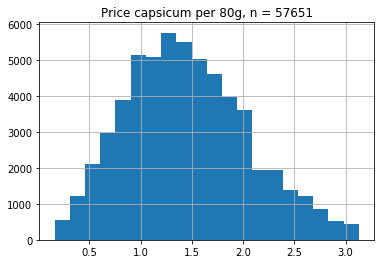

In [1115]:
subz = df8[df8['BARCODE'] == '9310151810443']
graph = subz['PRICE'].astype(float).hist(bins = 20)
graph.set_title('Price capsicum per 80g, n = ' + str(subz.shape[0]));

In [1173]:
prices = df8[df8['BARCODE'] == '9310151810443']['PRICE'].astype(float)
print(np.mean(prices))
print(np.median(prices))
print(skew(prices))

1.4543444172694577
1.4
0.3755387211864852


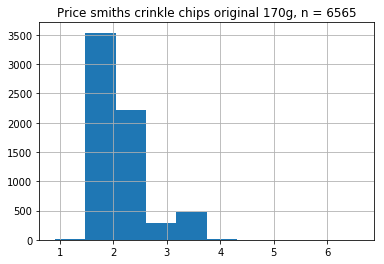

In [1243]:
subz = df8[df8['BARCODE'] == '9310015241888']
graph = subz['PRICE'].astype(float).hist(bins = 10)
graph.set_title('Price smiths crinkle chips original 170g, n = ' + str(subz.shape[0]));

In [1174]:
prices = df8[df8['BARCODE'] == '9310015241888']['PRICE'].astype(float)
print(np.mean(prices))
print(np.median(prices))
print(skew(prices))

2.158095963442443
2.0
0.840554492050047


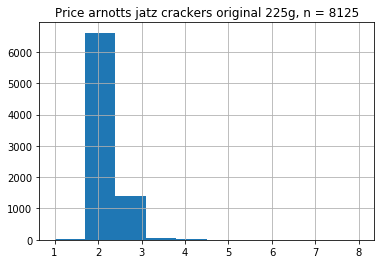

In [1133]:
subz = df8[df8['BARCODE'] == '9310072026404']
graph = subz['PRICE'].astype(float).hist(bins = 10)
graph.set_title('Price arnotts jatz crackers original 225g, n = ' + str(subz.shape[0]));

In [1175]:
prices = df8[df8['BARCODE'] == '9310072026404']['PRICE'].astype(float)
print(np.mean(prices))
print(np.median(prices))
print(skew(prices))

2.1749673846153805
2.0
2.193323419716344


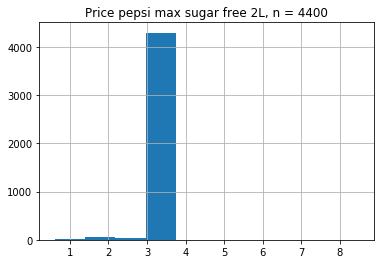

In [1240]:


subz = df8[df8['BARCODE'] == '9300633231798']
graph = subz['PRICE'].astype(float).hist(bins = 10)
graph.set_title('Woolworths select lite milk 3L, n = ' + str(subz.shape[0]));

In [1241]:
prices = df8[df8['BARCODE'] == '9300633231798']['PRICE'].astype(float)
print(np.mean(prices))
print(np.median(prices))
print(skew(prices))

2.9927159090908644
3.0
-1.4090068518040197


In [1740]:
df['CPI category'].value_counts()

Snacks and confectionery EC            2429
Waters, soft drinks and juices EC      1546
Other food products n.e.c. EC          1544
Vegetables EC                          1433
Cakes and biscuits EC                  1405
Food additives & condiments EC         1390
Ice cream & other dairy products EC    1013
Cheese EC                               841
Fish and other seafood EC               738
Other cereal products EC                673
Fruit EC                                504
Breakfast cereals EC                    494
Milk EC                                 445
Oils and fats EC                        412
Other meats EC                          383
Jams, honey and spreads EC              362
Bread EC                                328
Coffee, tea and cocoa EC                257
Pork EC                                 140
Beef and veal EC                         85
Poultry EC                               81
Eggs EC                                  68
Ice cream&other dairy prod  EC  

In [1217]:
print(np.abs(skew_series)[((skew_series)<-1)].shape)
print(np.abs(skew_series)[((skew_series)<-0.5) & ((skew_series)>=-1)].shape)
print(np.abs(skew_series)[np.abs(skew_series)<=0.5].shape)
print(np.abs(skew_series)[((skew_series)>0.5) & ((skew_series)<=1)].shape)
print(np.abs(skew_series)[(skew_series>1)].shape)

(3604,)
(1495,)
(4880,)
(1750,)
(4996,)


In [1219]:
print(3604/16725)
print(1495/16725)
print(4880/16725)
print(1750/16725)
print(4996/16725)

0.21548579970104634
0.08938714499252616
0.29177877428998505
0.10463378176382661
0.29871449925261584


In [1586]:
df.groupby('CPI category')['Group Health Star Category'].nunique()

CPI category
Beef and veal EC                       1
Bread EC                               1
Breakfast cereals EC                   1
Cakes and biscuits EC                  1
Cheese EC                              3
Coffee, tea and cocoa EC               3
Eggs EC                                1
Fish and other seafood EC              1
Fish and other seafood EC              1
Food additives & condiments EC         1
Fruit EC                               1
Ice cream & other dairy products EC    2
Ice cream&other dairy prod  EC         1
Jams, honey and spreads EC             1
Lamb and goat EC                       1
Milk EC                                2
Oils and fats EC                       1
Other cereal products EC               1
Other food products n.e.c. EC          1
Other meats EC                         1
Pork EC                                1
Poultry EC                             1
Snacks and confectionery EC            1
Vegetables EC                          1
Wat

In [1245]:
df.groupby('CPI category')['Group Health Star Category'].nunique()

CPI category
Beef and veal EC                       1
Bread EC                               1
Breakfast cereals EC                   1
Cakes and biscuits EC                  1
Cheese EC                              3
Coffee, tea and cocoa EC               3
Eggs EC                                1
Fish and other seafood EC              1
Fish and other seafood EC              1
Food additives & condiments EC         1
Fruit EC                               1
Ice cream & other dairy products EC    2
Ice cream&other dairy prod  EC         1
Jams, honey and spreads EC             1
Lamb and goat EC                       1
Milk EC                                2
Oils and fats EC                       1
Other cereal products EC               1
Other food products n.e.c. EC          1
Other meats EC                         1
Pork EC                                1
Poultry EC                             1
Snacks and confectionery EC            1
Vegetables EC                          1
Wat

In [1587]:
c1 = (df['Group Health Star Category'] == '2')
c2 = (df['Mapped NPSC']<-11)
c3 = (df['Mapped NPSC']>25)

df['Mapped NPSC'] = np.where(c1&c2, -11, df['Mapped NPSC'])
df['Mapped NPSC'] = np.where(c1&c3, 25, df['Mapped NPSC'])

In [1589]:
df[df['CPI category'] == 'Milk EC']['Group Health Star Category'].value_counts()

1D    439
2       6
Name: Group Health Star Category, dtype: int64

In [1590]:
df[df['CPI category'] == 'Milk EC']['Group Health Star Category'].value_counts()

1D    439
2       6
Name: Group Health Star Category, dtype: int64

In [1591]:
df[df['CPI category'] == 'Cheese EC']['Group Health Star Category'].value_counts()

3D    738
2      70
2D     33
Name: Group Health Star Category, dtype: int64

In [1592]:
df[df['CPI category'] == 'Coffee, tea and cocoa EC']['Leaf category'].value_counts()

Tea                                          97
Flavoured coffee and tea powders             69
Hot chocolate                                38
Other flavourings for milk (e.g. Nesquik)    32
Instant coffee powder and pods               16
Coffee whitener                               5
Name: Leaf category, dtype: int64

In [1593]:
df[df['CPI category'] == 'Ice cream & other dairy products EC']['Group Health Star Category'].value_counts()

2     545
2D    469
Name: Group Health Star Category, dtype: int64

In [1594]:
c1 = (df['CPI category'] == 'Milk EC')
c2 = (df['Group Health Star Category'] == '1D')
c3 = (df['Group Health Star Category'] == '2')
df[c1&c2]['Leaf category'].value_counts()

Fresh dairy milk                                      113
Plain other milk                                       46
Long life dairy milk                                   43
Coffee flavoured dairy milk                            43
Chocolate flavoured dairy milk                         35
Plain soy milk                                         34
Strawberry flavoured dairy milk                        23
Probiotic drinks                                       19
Flavoured other milk                                   19
Coconut milk (to drink)                                18
Plain lactose-free milk                                15
Other flavoured dairy milk not otherwise specified     12
Vanilla flavoured dairy milk                            7
Evaporated milk                                         4
Flavoured lactose-free milk                             4
Flavoured soy milk                                      4
Name: Leaf category, dtype: int64

In [1595]:
df[c1&c3]['Leaf category'].value_counts()

Condensed milk    6
Name: Leaf category, dtype: int64

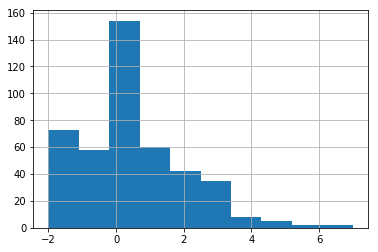

In [1285]:
df[c1&c2]['Mapped NPSC'].hist()

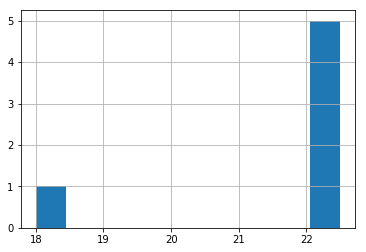

In [1286]:
df[c1&c3]['Mapped NPSC'].hist()

In [ ]:
How to normalize NPSC values:
    - using NPSC range in a given category?
    - normalizing NPSC table?

In [1596]:
df['Normalized NPSC'] = ((df[df['Group Health Star Category'] == '1']['Mapped NPSC'] --6)/9)

In [1597]:
c1 = (df['Normalized NPSC'].isnull())
c2 = (df['Group Health Star Category'] == '1D')
df['Normalized NPSC'] = np.where(c1&c2, (df['Mapped NPSC']--2)/9,  df['Normalized NPSC'])

In [1598]:
c1 = (df['Normalized NPSC'].isnull())
c2 = (df['Group Health Star Category'] == '2')
df['Normalized NPSC'] = np.where(c1&c2, (df['Mapped NPSC']--11)/36,  df['Normalized NPSC'])

In [1599]:
c1 = (df['Normalized NPSC'].isnull())
c2 = (df['Group Health Star Category'] == '2D')
df['Normalized NPSC'] = np.where(c1&c2, (df['Mapped NPSC']--2)/9,  df['Normalized NPSC'])

In [1600]:
c1 = (df['Normalized NPSC'].isnull())
c2 = (df['Group Health Star Category'] == '3')
df['Normalized NPSC'] = np.where(c1&c2, (df['Mapped NPSC']-13)/29,  df['Normalized NPSC'])

In [1601]:
c1 = (df['Normalized NPSC'].isnull())
c2 = (df['Group Health Star Category'] == '3D')
df['Normalized NPSC'] = np.where(c1&c2, (df['Mapped NPSC']-22)/17,  df['Normalized NPSC'])

In [1602]:
def one(nums):
    return np.percentile(nums, 20)

def two(nums):
    return np.percentile(nums, 40)

def three(nums):
    return np.percentile(nums, 60)

def four(nums):
    return np.percentile(nums, 80)

In [1603]:
yes = pd.DataFrame()
yes['Category'] = df.groupby('CPI category')['CPI category'].count().index.tolist()
yes['Freq'] = df.groupby('CPI category')['CPI category'].count().tolist()
yes['Minimum'] = df.groupby('CPI category')['Normalized NPSC'].min().tolist()
yes['20th percentile'] = df.groupby('CPI category')['Normalized NPSC'].apply(one).tolist()
yes['40th percentile'] = df.groupby('CPI category')['Normalized NPSC'].apply(two).tolist()
yes['60th percentile'] = df.groupby('CPI category')['Normalized NPSC'].apply(three).tolist()
yes['80th percentile'] = df.groupby('CPI category')['Normalized NPSC'].apply(four).tolist()
yes['Maximum'] = df.groupby('CPI category')['Normalized NPSC'].max().tolist()




In [1604]:
yes

,Category,Freq,Minimum,20th percentile,40th percentile,60th percentile,80th percentile,Maximum
0,Beef and veal EC,85,0.000000,0.194444,0.319444,0.680556,0.805556,0.930556
1,Bread EC,347,0.000000,0.194444,0.194444,0.194444,0.319444,1.000000
2,Breakfast cereals EC,494,0.000000,0.041667,0.194444,0.194444,0.319444,0.805556
3,Cakes and biscuits EC,1461,0.000000,0.555556,0.680556,0.805556,0.930556,1.000000
4,Cheese EC,841,0.000000,0.205882,0.441176,0.676471,0.794118,1.000000
5,"Coffee, tea and cocoa EC",257,0.000000,0.333333,0.666667,0.666667,0.888889,1.000000
6,Eggs EC,68,0.194444,0.194444,0.194444,0.194444,0.194444,0.194444
7,Fish and other seafood EC,738,0.069444,0.194444,0.194444,0.319444,0.319444,1.000000
8,Fish and other seafood EC,9,0.055556,0.055556,0.083333,0.105556,0.138889,0.138889
9,Food additives & condiments EC,1404,0.000000,0.319444,0.555556,0.805556,0.930556,1.000000


In [1490]:
yes

,Category,Freq,Minimum,20th percentile,40th percentile,60th percentile,80th percentile,Maximum
0,Beef and veal EC,85,0.000000,0.194444,0.319444,0.680556,0.805556,0.930556
1,Bread EC,328,0.000000,0.194444,0.194444,0.194444,0.319444,1.000000
2,Breakfast cereals EC,494,0.000000,0.041667,0.194444,0.194444,0.319444,0.805556
3,Cakes and biscuits EC,1405,0.000000,0.555556,0.680556,0.805556,0.930556,1.000000
4,Cheese EC,841,0.000000,0.205882,0.441176,0.676471,0.794118,1.000000
5,"Coffee, tea and cocoa EC",257,0.000000,0.333333,0.666667,0.666667,0.888889,1.000000
6,Eggs EC,68,0.194444,0.194444,0.194444,0.194444,0.194444,0.194444
7,Fish and other seafood EC,738,0.069444,0.194444,0.194444,0.319444,0.319444,1.000000
8,Fish and other seafood EC,9,0.055556,0.055556,0.083333,0.105556,0.138889,0.138889
9,Food additives & condiments EC,1390,0.000000,0.319444,0.555556,0.805556,0.930556,1.000000


In [1605]:
df = df.merge(yes, how = 'left', left_on = 'CPI category', right_on = 'Category')

In [1606]:
c1 = (df['Normalized NPSC']<= df['20th percentile'])
c2 = (df['Normalized NPSC']<=df['60th percentile']) & (df['Normalized NPSC']>=df['40th percentile'])
c3 = (df['Normalized NPSC']>= df['80th percentile'])

In [1607]:
df['Basket'] = np.NaN
df['Basket'] = np.where(c1, 'Healthy', df['Basket'])
df['Basket'] = np.where(c2, 'Middle', df['Basket'])
df['Basket'] = np.where(c3, 'Unhealthy', df['Basket'])

df['Basket'] = np.where(c1&c2, 'Healthy/middle', df['Basket'])
df['Basket'] = np.where(c2&c3, 'Middle/unhealthy', df['Basket'])

df['Basket'] = np.where(c1&c2&c3, 'Healthy/middle/unhealthy', df['Basket'])

In [1608]:
df['Basket'].value_counts()

Middle                      4586
Unhealthy                   4194
Healthy                     3573
nan                         2130
Healthy/middle              1730
Middle/unhealthy             444
Healthy/middle/unhealthy      68
Name: Basket, dtype: int64

In [1609]:
df = df[['BARCODE', 'MANUFACTURER', 'BC DESC', 'Leaf category',
       'CPI category', 'Presence HSR','HSR Score',
       'Mapped NPSC', 'Group Health Star Category', 
    'Normalized NPSC', 'Basket',
    
    'SIZE', 'UOM',
       'Package Size', 'Energy (kJ) Per 100 ( kJ )']]

In [ ]:
determining CPI category

determining normalized NPSC and basket assignment

determining product price

In [1613]:
df8['PRICE'] = df8['PRICE'].astype(float)

In [1614]:
df9 = pd.DataFrame()
df9['BARCODE'] = df8.groupby('BARCODE')['PRICE'].median().index.tolist()
df9['PRICE'] = df8.groupby('BARCODE')['PRICE'].median().tolist()

In [1615]:
df = df.merge(df9, on = 'BARCODE', how = 'left')

In [1616]:
df = df[['BARCODE', 'MANUFACTURER', 'BC DESC', 'Leaf category',
       'CPI category', 'Presence HSR','HSR Score',
       'Mapped NPSC', 'Group Health Star Category', 
    'Normalized NPSC', 'Basket',
    
    'SIZE', 'Energy (kJ) Per 100 ( kJ )', 'PRICE']]

In [1618]:
df

,BARCODE,MANUFACTURER,BC DESC,Leaf category,CPI category,Presence HSR,HSR Score,Mapped NPSC,Group Health Star Category,Normalized NPSC,Basket,SIZE,Energy (kJ) Per 100 ( kJ ),PRICE
0,26320953,ALDI,SPRINTERS STACKED CHIPS SOUR CREAM & ONION 160G,Sour cream and chives potato crisps,Snacks and confectionery EC,1,1.5,18.0,2,0.805556,Middle,160,2100,1.590
1,9320823003028,TUCKERS NATURAL,TUCKERS GOURMET ROSEMARY SALT CRACKERS 110G,Flavoured crackers and crispbread,Cakes and biscuits EC,0,1.5,18.0,2,0.805556,Middle,110,1840,3.000
2,9300601259625,COLES,COLES SULTANA 1KG,Dried fruit without nuts/seeds,Fruit EC,1,3,4.5,2,0.430556,Unhealthy,1000,1390,5.350
3,9350177000091,ICONIC FOOD,SIRENA TUNA LEMON BASIL AND CHILLI 95G,Flavoured canned tuna,Fish and other seafood EC,0,3.5,0.5,2,0.319444,Middle/unhealthy,95,1029,2.150
4,9310434001636,MONDELEZ INTERNATIONAL,THE NATURAL CONFECTIONERY CO SOUR CHEWS 220G,Soft sugar-based confectionery,Snacks and confectionery EC,0,1.5,18.0,2,0.805556,Middle,220,1570,2.500
5,9311257202446,GREENS GENERAL FOODS,PARADISE RICH SHORTBREAD 200G,Shortbread style biscuits,Cakes and biscuits EC,0,1,22.5,2,0.930556,Unhealthy,200,2080,1.500
6,9300601376131,COLES,COLES REAL BEEF LIQUID STOCK 1L,Stock (as liquid),Food additives & condiments EC,1,3,4.5,2,0.430556,nan,1000,32,1.900
7,9300652808070,SANITARIUM,SANITARIUM SO GOOD ALMOND & SALTED CARAMEL 475ML,Soy-based ice cream,Ice cream & other dairy products EC,1,3.5,0.5,2,0.319444,Healthy,475,806,5.500
8,9300633386221,WOOLWORTHS,WOOLWORTHS ESSENTIALS BLENDED VEGETABLE OIL 2L,Cooking oils,Oils and fats EC,1,4,18.5,3,0.189655,Healthy,2000,3390,4.400
9,9300633634513,WOOLWORTHS,MACRO TURMERIC & GINGER ALMONDS 250G,Savoury-coated nuts,Snacks and confectionery EC,1,5,-11.0,2,0.000000,Healthy,250,2530,7.500


In [ ]:
data = []

In [1697]:
df['CPI category'].value_counts().index.tolist()

['Snacks and confectionery EC',
 'Waters, soft drinks and juices EC',
 'Other food products n.e.c. EC',
 'Vegetables EC',
 'Cakes and biscuits EC',
 'Food additives & condiments EC',
 'Ice cream & other dairy products EC',
 'Cheese EC',
 'Fish and other seafood EC',
 'Other cereal products EC ',
 'Fruit EC',
 'Breakfast cereals EC',
 'Milk EC',
 'Oils and fats EC',
 'Other meats EC',
 'Jams, honey and spreads EC',
 'Bread EC',
 'Coffee, tea and cocoa EC',
 'Pork EC',
 'Beef and veal EC',
 'Poultry EC',
 'Eggs EC',
 'Ice cream&other dairy prod  EC',
 'Lamb and goat EC',
 'Fish and other seafood EC ']

In [1732]:
cats = df['CPI category'].value_counts().index.tolist()
big = pd.DataFrame()
for cat in cats:
    
    
    subset = df[df['CPI category'] == cat]
    print(cat)
    go = pd.DataFrame(subset['Leaf category'].value_counts())
    healthy = pd.DataFrame(subset[subset['Basket'].str.contains('Healthy')]['Leaf category'].value_counts(normalize=True)*100)
    middle = pd.DataFrame(subset[subset['Basket'].str.lower().str.contains('middle')]['Leaf category'].value_counts(normalize=True)*100)
    unhealthy = pd.DataFrame(subset[subset['Basket'].str.lower().str.contains('unhealthy')]['Leaf category'].value_counts(normalize=True)*100)

    go = go.merge(healthy, right_index=True, left_index=True, how = 'left')
    go = go.merge(middle, right_index=True, left_index=True, how = 'left')
    go = go.merge(unhealthy, right_index=True, left_index=True, how = 'left')

    go.columns = [1, 2, 3, 4]

    go = go[[2, 3, 4]]
    go.columns = ['Healthy', 'Middle', 'Unhealthy']


    go = go.sort_values(by = 'Healthy', ascending=False)
    
    go['CPI category'] = cat
    
    big = pd.concat([big, go])
    
    

Snacks and confectionery EC
Waters, soft drinks and juices EC
Other food products n.e.c. EC
Vegetables EC
Cakes and biscuits EC
Food additives & condiments EC
Ice cream & other dairy products EC
Cheese EC
Fish and other seafood EC
Other cereal products EC 
Fruit EC
Breakfast cereals EC
Milk EC
Oils and fats EC
Other meats EC
Jams, honey and spreads EC
Bread EC
Coffee, tea and cocoa EC
Pork EC
Beef and veal EC
Poultry EC
Eggs EC
Ice cream&other dairy prod  EC
Lamb and goat EC
Fish and other seafood EC 


In [1733]:
big['Leaf category'] = big.index.tolist()

In [1734]:
big.reset_index(drop=True, inplace=True)

In [1735]:
big = big[['CPI category', 'Leaf category', 'Healthy', 'Middle', 'Unhealthy']]

In [1737]:
big.to_excel('basket composition.xlsx', index=False)

In [1623]:
df['Basket'].value_counts()

Middle                      4546
Unhealthy                   4165
Healthy                     3557
nan                         2125
Healthy/middle              1718
Middle/unhealthy             444
Healthy/middle/unhealthy      68
Name: Basket, dtype: int64

In [1738]:
df.to_excel('Food basket prep.xlsx', index=False)

In [1741]:
df.head(1)

,BARCODE,MANUFACTURER,BC DESC,Leaf category,CPI category,Presence HSR,HSR Score,Mapped NPSC,Group Health Star Category,Normalized NPSC,Basket,SIZE,Energy (kJ) Per 100 ( kJ ),PRICE
0,26320953,ALDI,SPRINTERS STACKED CHIPS SOUR CREAM & ONION 160G,Sour cream and chives potato crisps,Snacks and confectionery EC,1,1.5,18.0,2,0.805556,Middle,160,2100,1.59


In [1744]:
df.groupby('CPI category')['Group Health Star Category'].nunique()

CPI category
Beef and veal EC                       1
Bread EC                               1
Breakfast cereals EC                   1
Cakes and biscuits EC                  1
Cheese EC                              3
Coffee, tea and cocoa EC               3
Eggs EC                                1
Fish and other seafood EC              1
Fish and other seafood EC              1
Food additives & condiments EC         1
Fruit EC                               1
Ice cream & other dairy products EC    2
Ice cream&other dairy prod  EC         1
Jams, honey and spreads EC             1
Lamb and goat EC                       1
Milk EC                                2
Oils and fats EC                       1
Other cereal products EC               1
Other food products n.e.c. EC          1
Other meats EC                         1
Pork EC                                1
Poultry EC                             1
Snacks and confectionery EC            1
Vegetables EC                          1
Wat

In [1790]:
subset = df[df['CPI category'] == 'Milk EC']

In [1791]:
subset['Group Health Star Category'].value_counts()

1D    439
2       6
Name: Group Health Star Category, dtype: int64

In [1792]:


1+2+1+4+3+3+3+2+1+2

22

Price of basket calculation

Example
- healthy basket with two categories - fruit (40%) and bread (60%)
- just four products with varying purchase frequency - apple (1), banana (3), multigrain bread (4) and brown bread (2)

Product prices


Fruit (40%) 
apple     $1/kg
banana    $2/kg
banana    $2/kg
banana    $5/kg



Bread (60%)
multigrain $4/kg
multigrain $4/kg
multigrain $6/kg
multigrain $6/kg
brown      $12/kg
brown      $12/kg



Option 1: average of product prices, weighted by category 

Basket price = 40% x average fruit price           + 60% x average bread price
             = 40% x (50% x apple  + 50% x banana) + 60% x (50% x multigrain + 50% x  brown)


Option 2: sales-weighted average of product prices, weighted by category

Basket price = 40% x sales-weighted average fruit price           + 60% x sales-weighted average bread price
             = 40% x (25% x apple  + 75% x banana)                + 60% x (67% x multigrain + 33% x  brown)




In [ ]:
how much do people usually spend on bananas - 300/1300


how much do people usually spend on apples - 1000/1300





In [1794]:
(1000+2+2+4)/(100+2+2+2)

9.50943396226415

In [1795]:
(1000/1300)*(20)+(300/1300)*(100)

38.46153846153846

In [1797]:
(1000+100+90+110)/(50+1+1+1)

24.528301886792452

In [1798]:
0.6*24.50+0.4*2.4

15.66

In [ ]:
simple average or sales weighted?

In [1806]:
(50/53)*20 + (1/53)*100 + (1/53)*100 + (1/53)*100

24.528301886792455

In [1810]:
(50/53)*20 + (1/53)*100

20.754716981132077

In [1811]:
0.25*20 + 0.75* 100

80.0

In [1816]:
snacks = df8[df8['CPI category'] =='Snacks and confectionery EC']

In [1824]:
df8 = df8.merge(df[['BARCODE', 'SIZE']], how = 'left', on = 'BARCODE')

In [1825]:
df8.head(1)

,BARCODE,GENERATION,HHID,SHOP,TRANS DATE,TRANS TIME,QTY,PRICE,EP,ON PROMO,PLU,WGT,BC DESC,CPI category,SIZE
0,26216591,1,015407,242,10/01/2018,12:01,1,0.69,1.00,0,NaN,NaN,DAIRY FINE DREEMY CHOCOLATE BAR 40G,Snacks and confectionery EC,40


In [1828]:
(1/2)*10 + (1/2)*2

6.0

In [ ]:



size-weighted
purchase-weighted
consumption-weighted

In [1820]:
snackers = pd.DataFrame()

snacks['BC DESC'].value_counts()

SMITHS CRINKLE ORIGINAL CHIPS 170G                        6565
DORITOS CORN CHIPS CHEESE SUPREME 170G                    5577
TWISTIES CHEESE 100G                                      5111
ARNOTTS THINS ORIGINAL 175G                               4757
SMITHS THINLY CUT SELECTION ORIGINAL 175G                 4748
FRYS TURISK DELIGHT BAR 55G                               4593
NIELSEN SWEETS/CHOCOLATE/LOLLIES                          4557
CHEEZELS CHEESE 110G                                      4557
SMITHS CRINKLE POTATO CHIPS CHEESE & ONION 170G           4533
SMITHS CRINKLE POTATO CHIPS SALT & VINEGAR 170G           4132
MARS BAR 53G                                              3876
CADBURY DAIRY MILK 350G                                   3752
CHERRY RIPE BARS CHOCOLATE 52G                            3704
CADBURY DAIRY MILK 200G                                   3678
CADBURY OLD GOLD OLD JAMAICA & RAISIN 200G                3416
KETTLE CHIP ORIGINAL SEA SALT 175G                     

In [1804]:
df8[df8['CPI category'] == df8['CPI category'].value_counts().index.tolist()[0]]

KeyboardInterrupt: 

In [1803]:
df8.head()

,BARCODE,GENERATION,HHID,SHOP,TRANS DATE,TRANS TIME,QTY,PRICE,EP,ON PROMO,PLU,WGT,BC DESC,CPI category
0,26216591,1,015407,242,10/01/2018,12:01,1,0.69,1.00,0,NaN,NaN,DAIRY FINE DREEMY CHOCOLATE BAR 40G,Snacks and confectionery EC
1,26216591,1,025593,242,10/01/2018,13:44,3,0.69,1.00,0,NaN,NaN,DAIRY FINE DREEMY CHOCOLATE BAR 40G,Snacks and confectionery EC
2,26216591,1,010528,242,12/01/2018,15:49,1,0.69,1.00,0,NaN,NaN,DAIRY FINE DREEMY CHOCOLATE BAR 40G,Snacks and confectionery EC
3,9344962001660,1,012051,023,24/01/2018,15:33,1,2.00,1.00,1,NaN,NaN,YOPRO HIGH PROTEIN PASSIONFRUIT YOGHURT 160G,Ice cream & other dairy products EC
4,9344962001660,1,019352,023,26/01/2018,13:08,2,2.00,1.00,1,NaN,NaN,YOPRO HIGH PROTEIN PASSIONFRUIT YOGHURT 160G,Ice cream & other dairy products EC


In [ ]:
apple 1
apple 2
basket weight = 80%

milk 1
milk 4
milk 3
basket weight = 10%

egg 3
egg 3
egg 2
egg 1
egg 2
basket weight = 10%






In [1786]:
subset[subset['Group Health Star Category'] == '2']['Leaf category'].value_counts().sum()

673

In [1787]:
(36+21+9+4)/673

0.10401188707280833

In [1780]:
subset['Leaf category'].value_counts()

Series([], Name: Leaf category, dtype: int64)

In [1782]:
df['CPI category'].value_counts().index.tolist()

['Snacks and confectionery EC',
 'Waters, soft drinks and juices EC',
 'Other food products n.e.c. EC',
 'Vegetables EC',
 'Cakes and biscuits EC',
 'Food additives & condiments EC',
 'Ice cream & other dairy products EC',
 'Cheese EC',
 'Fish and other seafood EC',
 'Other cereal products EC ',
 'Fruit EC',
 'Breakfast cereals EC',
 'Milk EC',
 'Oils and fats EC',
 'Other meats EC',
 'Jams, honey and spreads EC',
 'Bread EC',
 'Coffee, tea and cocoa EC',
 'Pork EC',
 'Beef and veal EC',
 'Poultry EC',
 'Eggs EC',
 'Ice cream&other dairy prod  EC',
 'Lamb and goat EC',
 'Fish and other seafood EC ']

In [1770]:
738/(738+70+33)

0.8775267538644471

In [ ]:
def NPSC(string):
    try:
        cat = string.split('|')[0]
        HSR = float(string.split('|')[-1])

        if cat == '1':
            if HSR == 0.5:
                return 3
            if HSR == 1:
                return 2
            if HSR == 1.5:
                return 1
            if HSR == 2:
                return 0
            if HSR == 2.5:
                return -1
            if HSR == 3:
                return -2
            if HSR == 3.5:
                return -3
            if HSR == 4:
                return -4
            if HSR == 4.5:
                return -5
            if HSR == 5:
                return -6

        if cat == '1D':
            if HSR == 0.5:
                return 7
            if HSR == 1:
                return 6
            if HSR == 1.5:
                return 5
            if HSR == 2:
                return 4
            if HSR == 2.5:
                return 3
            if HSR == 3:
                return 2
            if HSR == 3.5:
                return 1
            if HSR == 4:
                return 0
            if HSR == 4.5:
                return -1
            if HSR == 5:
                return -2

        if cat == '2':
            if HSR == 0.5:
                return 25
            if HSR == 1:
                return 22.5
            if HSR == 1.5:
                return 18
            if HSR == 2:
                return 13.5
            if HSR == 2.5:
                return 9
            if HSR == 3:
                return 4.5
            if HSR == 3.5:
                return 0.5
            if HSR == 4:
                return -4
            if HSR == 4.5:
                return -8.5
            if HSR == 5:
                return -11


        if cat == '2D':
            if HSR == 0.5:
                return 7
            if HSR == 1:
                return 6
            if HSR == 1.5:
                return 5
            if HSR == 2:
                return 4
            if HSR == 2.5:
                return 3
            if HSR == 3:
                return 2
            if HSR == 3.5:
                return 1
            if HSR == 4:
                return 0
            if HSR == 4.5:
                return -1
            if HSR == 5:
                return -2


        if cat == '3':
            if HSR == 0.5:
                return 42
            if HSR == 1:
                return 39.5
            if HSR == 1.5:
                return 36
            if HSR == 2:
                return 32.5
            if HSR == 2.5:
                return 29
            if HSR == 3:
                return 25.5
            if HSR == 3.5:
                return 22
            if HSR == 4:
                return 18.5
            if HSR == 4.5:
                return 15
            if HSR == 5:
                return 13


        if cat == '3D':
            if HSR == 0.5:
                return 39
            if HSR == 1:
                return 37.5
            if HSR == 1.5:
                return 35.5
            if HSR == 2:
                return 33.5
            if HSR == 2.5:
                return 31.5
            if HSR == 3:
                return 29.5
            if HSR == 3.5:
                return 27.5
            if HSR == 4:
                return 25.5
            if HSR == 4.5:
                return 23.5
            if HSR == 5:
                return 22
    except:
        return np.NaN